In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
BATCH_SIZE = 32
NUM_OF_WORKERS = 2
NUM_OF_EPOCHS = 40

trainset = datasets.FashionMNIST('data_original/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
testset = datasets.FashionMNIST('data_original/', download=True, train=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

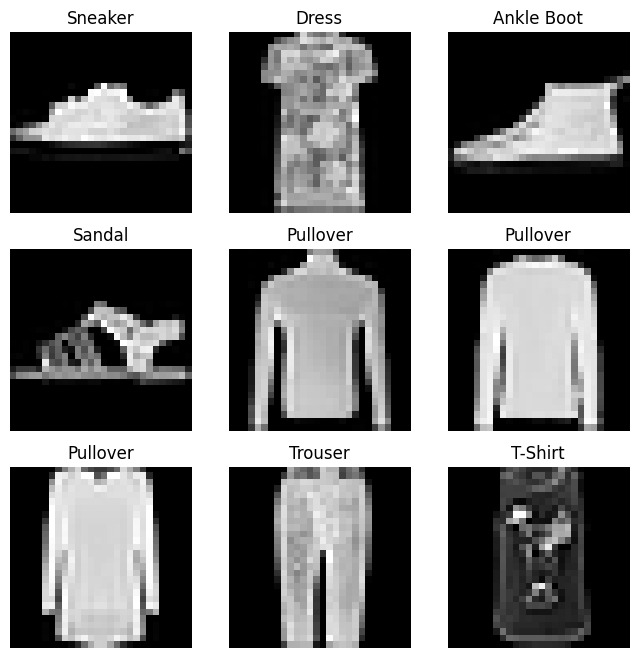

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [6]:
model.to(device)

GarmentClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [8]:
def train_and_validate_model(model, optimizer, loss_fn, trainloader, testloader):
    batch_tr_loss = {}
    batch_te_loss = {}
    
    best_test_loss = float('inf')
    
    # epoch loss and accuracy
    tr_loss, tr_acc = [], []
    te_loss, te_acc = [], []
    
    for t in (range(NUM_OF_EPOCHS)):
        model.train()
        batch_loss, batch_accuracy = [], []
        print(f"Epoch {t+1} Training...")
        for X,y in tqdm(trainloader):
            X = X.to(device)
            y = y.to(device)
            predicted = model(X)
            loss = loss_fn(predicted, y)
            batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
            batch_loss.append(float(loss.item()))
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        batches = len(batch_loss)
        tr_loss.append(sum(batch_loss)/batches)
        tr_acc.append(sum(batch_accuracy)/batches)
    
        model.eval()
        with torch.no_grad():
            batch_loss, batch_accuracy = [], []
            print(f"Epoch {t+1} Testing...")
            for X,y in tqdm(testloader):
                X = X.to(device)
                y = y.to(device)
                predicted = model(X)
                loss = loss_fn(predicted, y)
                batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
                batch_loss.append(float(loss.item()))
    
            batches = len(batch_loss)
            te_loss.append(sum(batch_loss)/batches)
            te_acc.append(sum(batch_accuracy)/batches)
    
        # Save the model's weights after each epoch
        torch.save(model.state_dict(), f"model_weights/{BATCH_SIZE}_model_weights.pth")
    
        # Check if the current test loss is the best so far
        if te_loss[-1] < best_test_loss:
            best_test_loss = te_loss[-1]
            # Save the model's weights with the best test loss
            torch.save(model.state_dict(), f"model_weights/{BATCH_SIZE}_best_model_weights.pth")
    
        print(f"Epoch {t+1}: Train_accuracy: {(100*tr_acc[-1]):>0.2f}%, Train_loss: {tr_loss[-1]:>8f}, Test_accuracy: {(100*te_acc[-1]):>0.2f}%, Test_loss: {te_loss[-1]:>8f}")
        
    return tr_loss, tr_acc, te_loss, te_acc

In [9]:
tr_loss, tr_acc, te_loss, te_acc = train_and_validate_model(model, optimizer, loss_fn, trainloader, testloader)

Epoch 1 Training...


100%|██████████| 1875/1875 [00:16<00:00, 110.74it/s]


Epoch 1 Testing...


100%|██████████| 313/313 [00:03<00:00, 80.79it/s] 


Epoch 1: Train_accuracy: 77.14%, Train_loss: 0.613528, Test_accuracy: 83.54%, Test_loss: 0.450152
Epoch 2 Training...


100%|██████████| 1875/1875 [00:14<00:00, 131.97it/s]


Epoch 2 Testing...


100%|██████████| 313/313 [00:03<00:00, 88.08it/s] 


Epoch 2: Train_accuracy: 85.86%, Train_loss: 0.388090, Test_accuracy: 86.18%, Test_loss: 0.385608
Epoch 3 Training...


100%|██████████| 1875/1875 [00:13<00:00, 134.42it/s]


Epoch 3 Testing...


100%|██████████| 313/313 [00:03<00:00, 89.03it/s] 


Epoch 3: Train_accuracy: 87.56%, Train_loss: 0.335608, Test_accuracy: 87.36%, Test_loss: 0.345766
Epoch 4 Training...


100%|██████████| 1875/1875 [00:15<00:00, 121.21it/s]


Epoch 4 Testing...


100%|██████████| 313/313 [00:05<00:00, 60.40it/s] 


Epoch 4: Train_accuracy: 88.68%, Train_loss: 0.305896, Test_accuracy: 88.16%, Test_loss: 0.320406
Epoch 5 Training...


100%|██████████| 1875/1875 [00:27<00:00, 68.64it/s] 


Epoch 5 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.67it/s] 


Epoch 5: Train_accuracy: 89.47%, Train_loss: 0.284012, Test_accuracy: 87.87%, Test_loss: 0.321116
Epoch 6 Training...


100%|██████████| 1875/1875 [00:14<00:00, 126.64it/s]


Epoch 6 Testing...


100%|██████████| 313/313 [00:04<00:00, 66.64it/s] 


Epoch 6: Train_accuracy: 90.04%, Train_loss: 0.267837, Test_accuracy: 89.05%, Test_loss: 0.310329
Epoch 7 Training...


100%|██████████| 1875/1875 [00:15<00:00, 120.37it/s]


Epoch 7 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.94it/s] 


Epoch 7: Train_accuracy: 90.55%, Train_loss: 0.252237, Test_accuracy: 89.59%, Test_loss: 0.294801
Epoch 8 Training...


100%|██████████| 1875/1875 [00:16<00:00, 115.19it/s]


Epoch 8 Testing...


100%|██████████| 313/313 [00:05<00:00, 58.93it/s] 


Epoch 8: Train_accuracy: 91.05%, Train_loss: 0.241061, Test_accuracy: 89.42%, Test_loss: 0.291155
Epoch 9 Training...


100%|██████████| 1875/1875 [00:16<00:00, 111.70it/s]


Epoch 9 Testing...


100%|██████████| 313/313 [00:04<00:00, 73.32it/s] 


Epoch 9: Train_accuracy: 91.27%, Train_loss: 0.231906, Test_accuracy: 89.62%, Test_loss: 0.290086
Epoch 10 Training...


100%|██████████| 1875/1875 [00:17<00:00, 108.68it/s]


Epoch 10 Testing...


100%|██████████| 313/313 [00:05<00:00, 54.79it/s] 


Epoch 10: Train_accuracy: 91.69%, Train_loss: 0.220953, Test_accuracy: 88.56%, Test_loss: 0.323603
Epoch 11 Training...


100%|██████████| 1875/1875 [00:18<00:00, 100.81it/s]


Epoch 11 Testing...


100%|██████████| 313/313 [00:03<00:00, 94.74it/s] 


Epoch 11: Train_accuracy: 92.07%, Train_loss: 0.211856, Test_accuracy: 89.92%, Test_loss: 0.286524
Epoch 12 Training...


100%|██████████| 1875/1875 [00:13<00:00, 136.79it/s]


Epoch 12 Testing...


100%|██████████| 313/313 [00:03<00:00, 95.86it/s] 


Epoch 12: Train_accuracy: 92.34%, Train_loss: 0.203494, Test_accuracy: 90.11%, Test_loss: 0.280489
Epoch 13 Training...


100%|██████████| 1875/1875 [00:15<00:00, 121.61it/s]


Epoch 13 Testing...


100%|██████████| 313/313 [00:03<00:00, 88.31it/s] 


Epoch 13: Train_accuracy: 92.59%, Train_loss: 0.196891, Test_accuracy: 89.62%, Test_loss: 0.299202
Epoch 14 Training...


100%|██████████| 1875/1875 [00:14<00:00, 131.51it/s]


Epoch 14 Testing...


100%|██████████| 313/313 [00:03<00:00, 94.50it/s] 


Epoch 14: Train_accuracy: 92.83%, Train_loss: 0.189631, Test_accuracy: 89.78%, Test_loss: 0.286775
Epoch 15 Training...


100%|██████████| 1875/1875 [00:16<00:00, 116.55it/s]


Epoch 15 Testing...


100%|██████████| 313/313 [00:05<00:00, 59.67it/s] 


Epoch 15: Train_accuracy: 93.05%, Train_loss: 0.183242, Test_accuracy: 89.49%, Test_loss: 0.314589
Epoch 16 Training...


100%|██████████| 1875/1875 [00:20<00:00, 93.08it/s] 


Epoch 16 Testing...


100%|██████████| 313/313 [00:04<00:00, 76.74it/s] 


Epoch 16: Train_accuracy: 93.41%, Train_loss: 0.175007, Test_accuracy: 89.32%, Test_loss: 0.317847
Epoch 17 Training...


100%|██████████| 1875/1875 [00:17<00:00, 108.16it/s]


Epoch 17 Testing...


100%|██████████| 313/313 [00:03<00:00, 81.54it/s] 


Epoch 17: Train_accuracy: 93.52%, Train_loss: 0.168975, Test_accuracy: 89.81%, Test_loss: 0.305757
Epoch 18 Training...


100%|██████████| 1875/1875 [00:14<00:00, 133.64it/s]


Epoch 18 Testing...


100%|██████████| 313/313 [00:03<00:00, 96.21it/s] 


Epoch 18: Train_accuracy: 93.86%, Train_loss: 0.164332, Test_accuracy: 89.70%, Test_loss: 0.316204
Epoch 19 Training...


100%|██████████| 1875/1875 [00:14<00:00, 131.99it/s]


Epoch 19 Testing...


100%|██████████| 313/313 [00:03<00:00, 87.91it/s] 


Epoch 19: Train_accuracy: 93.98%, Train_loss: 0.158102, Test_accuracy: 90.16%, Test_loss: 0.317312
Epoch 20 Training...


100%|██████████| 1875/1875 [00:14<00:00, 125.16it/s]


Epoch 20 Testing...


100%|██████████| 313/313 [00:03<00:00, 97.57it/s] 


Epoch 20: Train_accuracy: 94.22%, Train_loss: 0.150434, Test_accuracy: 89.99%, Test_loss: 0.321535
Epoch 21 Training...


100%|██████████| 1875/1875 [00:13<00:00, 137.38it/s]


Epoch 21 Testing...


100%|██████████| 313/313 [00:03<00:00, 91.97it/s] 


Epoch 21: Train_accuracy: 94.40%, Train_loss: 0.147744, Test_accuracy: 89.53%, Test_loss: 0.346222
Epoch 22 Training...


100%|██████████| 1875/1875 [00:15<00:00, 123.19it/s]


Epoch 22 Testing...


100%|██████████| 313/313 [00:03<00:00, 84.06it/s] 


Epoch 22: Train_accuracy: 94.63%, Train_loss: 0.140349, Test_accuracy: 89.57%, Test_loss: 0.355268
Epoch 23 Training...


100%|██████████| 1875/1875 [00:15<00:00, 122.61it/s]


Epoch 23 Testing...


100%|██████████| 313/313 [00:03<00:00, 93.32it/s] 


Epoch 23: Train_accuracy: 94.78%, Train_loss: 0.137786, Test_accuracy: 89.30%, Test_loss: 0.339987
Epoch 24 Training...


100%|██████████| 1875/1875 [00:13<00:00, 136.48it/s]


Epoch 24 Testing...


100%|██████████| 313/313 [00:03<00:00, 98.04it/s] 


Epoch 24: Train_accuracy: 94.98%, Train_loss: 0.130970, Test_accuracy: 88.58%, Test_loss: 0.396655
Epoch 25 Training...


100%|██████████| 1875/1875 [00:14<00:00, 128.41it/s]


Epoch 25 Testing...


100%|██████████| 313/313 [00:03<00:00, 88.45it/s] 


Epoch 25: Train_accuracy: 95.16%, Train_loss: 0.126374, Test_accuracy: 89.51%, Test_loss: 0.379985
Epoch 26 Training...


100%|██████████| 1875/1875 [00:14<00:00, 128.71it/s]


Epoch 26 Testing...


100%|██████████| 313/313 [00:03<00:00, 95.11it/s] 


Epoch 26: Train_accuracy: 95.37%, Train_loss: 0.121982, Test_accuracy: 89.70%, Test_loss: 0.368914
Epoch 27 Training...


100%|██████████| 1875/1875 [00:14<00:00, 131.86it/s]


Epoch 27 Testing...


100%|██████████| 313/313 [00:03<00:00, 81.92it/s] 


Epoch 27: Train_accuracy: 95.42%, Train_loss: 0.119547, Test_accuracy: 89.56%, Test_loss: 0.375133
Epoch 28 Training...


100%|██████████| 1875/1875 [00:15<00:00, 120.73it/s]


Epoch 28 Testing...


100%|██████████| 313/313 [00:03<00:00, 93.76it/s] 


Epoch 28: Train_accuracy: 95.77%, Train_loss: 0.112311, Test_accuracy: 89.04%, Test_loss: 0.409195
Epoch 29 Training...


100%|██████████| 1875/1875 [00:14<00:00, 130.51it/s]


Epoch 29 Testing...


100%|██████████| 313/313 [00:03<00:00, 84.24it/s] 


Epoch 29: Train_accuracy: 95.78%, Train_loss: 0.110866, Test_accuracy: 89.58%, Test_loss: 0.406908
Epoch 30 Training...


100%|██████████| 1875/1875 [00:15<00:00, 117.52it/s]


Epoch 30 Testing...


100%|██████████| 313/313 [00:03<00:00, 92.11it/s] 


Epoch 30: Train_accuracy: 95.90%, Train_loss: 0.107217, Test_accuracy: 89.05%, Test_loss: 0.434251
Epoch 31 Training...


100%|██████████| 1875/1875 [00:13<00:00, 135.84it/s]


Epoch 31 Testing...


100%|██████████| 313/313 [00:03<00:00, 95.61it/s] 


Epoch 31: Train_accuracy: 96.04%, Train_loss: 0.104393, Test_accuracy: 89.12%, Test_loss: 0.439284
Epoch 32 Training...


100%|██████████| 1875/1875 [00:14<00:00, 127.22it/s]


Epoch 32 Testing...


100%|██████████| 313/313 [00:03<00:00, 85.91it/s] 


Epoch 32: Train_accuracy: 96.17%, Train_loss: 0.099933, Test_accuracy: 89.22%, Test_loss: 0.486485
Epoch 33 Training...


100%|██████████| 1875/1875 [00:14<00:00, 125.14it/s]


Epoch 33 Testing...


100%|██████████| 313/313 [00:03<00:00, 93.76it/s] 


Epoch 33: Train_accuracy: 96.30%, Train_loss: 0.097172, Test_accuracy: 89.28%, Test_loss: 0.460795
Epoch 34 Training...


100%|██████████| 1875/1875 [00:14<00:00, 127.97it/s]


Epoch 34 Testing...


100%|██████████| 313/313 [00:03<00:00, 83.05it/s] 


Epoch 34: Train_accuracy: 96.34%, Train_loss: 0.094040, Test_accuracy: 88.97%, Test_loss: 0.479516
Epoch 35 Training...


100%|██████████| 1875/1875 [00:20<00:00, 92.16it/s] 


Epoch 35 Testing...


100%|██████████| 313/313 [00:07<00:00, 43.38it/s] 


Epoch 35: Train_accuracy: 96.37%, Train_loss: 0.095003, Test_accuracy: 89.01%, Test_loss: 0.484219
Epoch 36 Training...


100%|██████████| 1875/1875 [00:24<00:00, 77.88it/s] 


Epoch 36 Testing...


100%|██████████| 313/313 [00:05<00:00, 55.86it/s] 


Epoch 36: Train_accuracy: 96.63%, Train_loss: 0.088070, Test_accuracy: 89.25%, Test_loss: 0.491432
Epoch 37 Training...


100%|██████████| 1875/1875 [00:20<00:00, 91.45it/s] 


Epoch 37 Testing...


100%|██████████| 313/313 [00:04<00:00, 65.59it/s] 


Epoch 37: Train_accuracy: 96.65%, Train_loss: 0.087858, Test_accuracy: 89.28%, Test_loss: 0.508612
Epoch 38 Training...


100%|██████████| 1875/1875 [00:15<00:00, 123.22it/s]


Epoch 38 Testing...


100%|██████████| 313/313 [00:03<00:00, 92.86it/s] 


Epoch 38: Train_accuracy: 96.87%, Train_loss: 0.082163, Test_accuracy: 89.07%, Test_loss: 0.517061
Epoch 39 Training...


100%|██████████| 1875/1875 [00:15<00:00, 122.06it/s]


Epoch 39 Testing...


100%|██████████| 313/313 [00:03<00:00, 80.65it/s] 


Epoch 39: Train_accuracy: 96.86%, Train_loss: 0.082326, Test_accuracy: 89.25%, Test_loss: 0.510706
Epoch 40 Training...


100%|██████████| 1875/1875 [00:17<00:00, 107.93it/s]


Epoch 40 Testing...


100%|██████████| 313/313 [00:04<00:00, 65.28it/s] 

Epoch 40: Train_accuracy: 96.98%, Train_loss: 0.079962, Test_accuracy: 88.81%, Test_loss: 0.538449


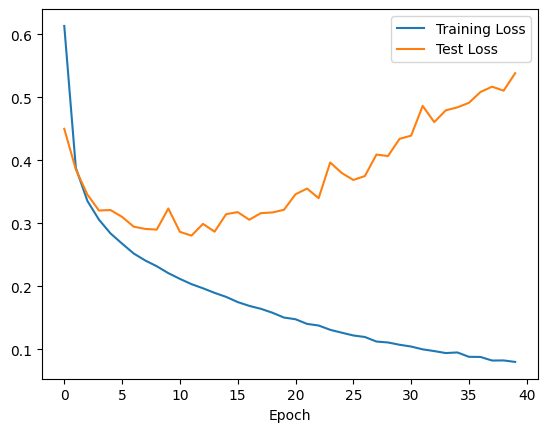

In [10]:
import matplotlib.pyplot as plt

# Plot the training loss and accuracy
plt.plot(tr_loss, label="Training Loss")
plt.plot(te_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

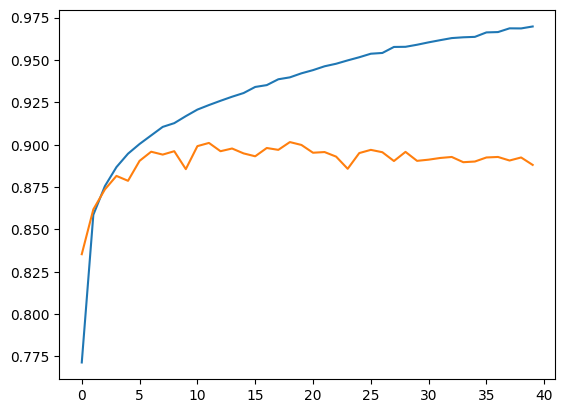

In [11]:
plt.plot(tr_acc, label="Training Accuracy")
plt.plot(te_acc, label="Test Accuracy")

In [12]:
torch.save(model.state_dict(), f"model_weights/simplecnn_model_weights.pth")

### MixUp

In [13]:
from torchvision.transforms import v2

In [14]:
NUM_CLASSES = 10
mixup = v2.MixUp(num_classes=NUM_CLASSES)

In [15]:
from torch.utils.data import default_collate

def collate_fn(batch):
    return mixup(*default_collate(batch))

trainloader_with_mixup = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS, collate_fn=collate_fn)
testloader_with_mixup = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS, collate_fn=collate_fn)

In [16]:
model = GarmentClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [17]:
tr_loss, tr_acc, te_loss, te_acc = train_and_validate_model(model, optimizer, loss_fn, trainloader, testloader)

Epoch 1 Training...


100%|██████████| 1875/1875 [00:22<00:00, 83.86it/s] 


Epoch 1 Testing...


100%|██████████| 313/313 [00:06<00:00, 50.08it/s] 


Epoch 1: Train_accuracy: 75.98%, Train_loss: 0.627382, Test_accuracy: 79.48%, Test_loss: 0.541956
Epoch 2 Training...


100%|██████████| 1875/1875 [00:15<00:00, 119.54it/s]


Epoch 2 Testing...


100%|██████████| 313/313 [00:03<00:00, 88.36it/s] 


Epoch 2: Train_accuracy: 85.10%, Train_loss: 0.404687, Test_accuracy: 83.74%, Test_loss: 0.431160
Epoch 3 Training...


100%|██████████| 1875/1875 [00:14<00:00, 129.77it/s]


Epoch 3 Testing...


100%|██████████| 313/313 [00:03<00:00, 81.03it/s] 


Epoch 3: Train_accuracy: 87.20%, Train_loss: 0.346453, Test_accuracy: 87.40%, Test_loss: 0.340876
Epoch 4 Training...


100%|██████████| 1875/1875 [00:15<00:00, 122.81it/s]


Epoch 4 Testing...


100%|██████████| 313/313 [00:03<00:00, 85.03it/s] 


Epoch 4: Train_accuracy: 88.39%, Train_loss: 0.314091, Test_accuracy: 87.90%, Test_loss: 0.332581
Epoch 5 Training...


100%|██████████| 1875/1875 [00:16<00:00, 116.38it/s]


Epoch 5 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.43it/s] 


Epoch 5: Train_accuracy: 89.16%, Train_loss: 0.290951, Test_accuracy: 88.70%, Test_loss: 0.313338
Epoch 6 Training...


100%|██████████| 1875/1875 [00:18<00:00, 99.76it/s] 


Epoch 6 Testing...


100%|██████████| 313/313 [00:05<00:00, 52.41it/s] 


Epoch 6: Train_accuracy: 89.71%, Train_loss: 0.274584, Test_accuracy: 89.23%, Test_loss: 0.298036
Epoch 7 Training...


100%|██████████| 1875/1875 [00:34<00:00, 54.50it/s] 


Epoch 7 Testing...


100%|██████████| 313/313 [00:08<00:00, 36.11it/s] 


Epoch 7: Train_accuracy: 90.16%, Train_loss: 0.259704, Test_accuracy: 89.23%, Test_loss: 0.296958
Epoch 8 Training...


100%|██████████| 1875/1875 [00:21<00:00, 88.75it/s] 


Epoch 8 Testing...


100%|██████████| 313/313 [00:06<00:00, 46.30it/s] 


Epoch 8: Train_accuracy: 90.81%, Train_loss: 0.245246, Test_accuracy: 89.16%, Test_loss: 0.299224
Epoch 9 Training...


100%|██████████| 1875/1875 [00:27<00:00, 67.86it/s] 


Epoch 9 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.25it/s] 


Epoch 9: Train_accuracy: 91.14%, Train_loss: 0.236560, Test_accuracy: 89.87%, Test_loss: 0.284037
Epoch 10 Training...


100%|██████████| 1875/1875 [00:20<00:00, 89.67it/s] 


Epoch 10 Testing...


100%|██████████| 313/313 [00:05<00:00, 57.96it/s] 


Epoch 10: Train_accuracy: 91.44%, Train_loss: 0.225834, Test_accuracy: 89.12%, Test_loss: 0.296941
Epoch 11 Training...


100%|██████████| 1875/1875 [00:15<00:00, 121.69it/s]


Epoch 11 Testing...


100%|██████████| 313/313 [00:03<00:00, 98.26it/s] 


Epoch 11: Train_accuracy: 91.81%, Train_loss: 0.215973, Test_accuracy: 89.44%, Test_loss: 0.296279
Epoch 12 Training...


100%|██████████| 1875/1875 [00:14<00:00, 131.76it/s]


Epoch 12 Testing...


100%|██████████| 313/313 [00:03<00:00, 82.92it/s] 


Epoch 12: Train_accuracy: 92.02%, Train_loss: 0.208578, Test_accuracy: 89.55%, Test_loss: 0.292125
Epoch 13 Training...


100%|██████████| 1875/1875 [00:18<00:00, 103.34it/s]


Epoch 13 Testing...


100%|██████████| 313/313 [00:05<00:00, 56.80it/s] 


Epoch 13: Train_accuracy: 92.38%, Train_loss: 0.198538, Test_accuracy: 90.03%, Test_loss: 0.295209
Epoch 14 Training...


100%|██████████| 1875/1875 [00:21<00:00, 86.10it/s] 


Epoch 14 Testing...


100%|██████████| 313/313 [00:04<00:00, 68.35it/s] 


Epoch 14: Train_accuracy: 92.65%, Train_loss: 0.191858, Test_accuracy: 89.95%, Test_loss: 0.294036
Epoch 15 Training...


100%|██████████| 1875/1875 [00:14<00:00, 132.58it/s]


Epoch 15 Testing...


100%|██████████| 313/313 [00:04<00:00, 63.09it/s] 


Epoch 15: Train_accuracy: 92.94%, Train_loss: 0.185928, Test_accuracy: 90.14%, Test_loss: 0.308997
Epoch 16 Training...


100%|██████████| 1875/1875 [00:21<00:00, 87.53it/s] 


Epoch 16 Testing...


100%|██████████| 313/313 [00:04<00:00, 65.94it/s] 


Epoch 16: Train_accuracy: 93.26%, Train_loss: 0.178551, Test_accuracy: 90.00%, Test_loss: 0.308937
Epoch 17 Training...


100%|██████████| 1875/1875 [00:21<00:00, 86.15it/s] 


Epoch 17 Testing...


100%|██████████| 313/313 [00:05<00:00, 57.29it/s] 


Epoch 17: Train_accuracy: 93.29%, Train_loss: 0.173039, Test_accuracy: 90.04%, Test_loss: 0.308532
Epoch 18 Training...


100%|██████████| 1875/1875 [00:24<00:00, 76.74it/s] 


Epoch 18 Testing...


100%|██████████| 313/313 [00:07<00:00, 40.07it/s] 


Epoch 18: Train_accuracy: 93.70%, Train_loss: 0.164680, Test_accuracy: 89.58%, Test_loss: 0.325356
Epoch 19 Training...


100%|██████████| 1875/1875 [00:15<00:00, 124.73it/s]


Epoch 19 Testing...


100%|██████████| 313/313 [00:03<00:00, 97.75it/s] 


Epoch 19: Train_accuracy: 93.80%, Train_loss: 0.160212, Test_accuracy: 90.44%, Test_loss: 0.315535
Epoch 20 Training...


100%|██████████| 1875/1875 [00:16<00:00, 114.01it/s]


Epoch 20 Testing...


100%|██████████| 313/313 [00:05<00:00, 54.12it/s] 


Epoch 20: Train_accuracy: 94.03%, Train_loss: 0.154309, Test_accuracy: 90.05%, Test_loss: 0.319502
Epoch 21 Training...


100%|██████████| 1875/1875 [00:19<00:00, 96.86it/s] 


Epoch 21 Testing...


100%|██████████| 313/313 [00:05<00:00, 56.54it/s] 


Epoch 21: Train_accuracy: 94.36%, Train_loss: 0.148294, Test_accuracy: 89.91%, Test_loss: 0.326271
Epoch 22 Training...


100%|██████████| 1875/1875 [00:20<00:00, 93.32it/s] 


Epoch 22 Testing...


100%|██████████| 313/313 [00:05<00:00, 60.93it/s] 


Epoch 22: Train_accuracy: 94.45%, Train_loss: 0.142159, Test_accuracy: 89.61%, Test_loss: 0.353307
Epoch 23 Training...


100%|██████████| 1875/1875 [00:13<00:00, 135.57it/s]


Epoch 23 Testing...


100%|██████████| 313/313 [00:03<00:00, 92.81it/s] 


Epoch 23: Train_accuracy: 94.60%, Train_loss: 0.141026, Test_accuracy: 89.93%, Test_loss: 0.355724
Epoch 24 Training...


100%|██████████| 1875/1875 [00:14<00:00, 127.59it/s]


Epoch 24 Testing...


100%|██████████| 313/313 [00:03<00:00, 95.75it/s] 


Epoch 24: Train_accuracy: 94.83%, Train_loss: 0.134233, Test_accuracy: 89.87%, Test_loss: 0.342383
Epoch 25 Training...


100%|██████████| 1875/1875 [00:17<00:00, 105.02it/s]


Epoch 25 Testing...


100%|██████████| 313/313 [00:05<00:00, 52.40it/s] 


Epoch 25: Train_accuracy: 94.96%, Train_loss: 0.131514, Test_accuracy: 90.24%, Test_loss: 0.364101
Epoch 26 Training...


100%|██████████| 1875/1875 [00:15<00:00, 124.28it/s]


Epoch 26 Testing...


100%|██████████| 313/313 [00:03<00:00, 99.93it/s] 


Epoch 26: Train_accuracy: 95.29%, Train_loss: 0.123835, Test_accuracy: 90.07%, Test_loss: 0.375011
Epoch 27 Training...


100%|██████████| 1875/1875 [00:13<00:00, 140.42it/s]


Epoch 27 Testing...


100%|██████████| 313/313 [00:03<00:00, 94.98it/s] 


Epoch 27: Train_accuracy: 95.24%, Train_loss: 0.122429, Test_accuracy: 89.93%, Test_loss: 0.375193
Epoch 28 Training...


100%|██████████| 1875/1875 [00:15<00:00, 119.95it/s]


Epoch 28 Testing...


100%|██████████| 313/313 [00:04<00:00, 70.00it/s] 


Epoch 28: Train_accuracy: 95.45%, Train_loss: 0.119315, Test_accuracy: 89.74%, Test_loss: 0.376730
Epoch 29 Training...


100%|██████████| 1875/1875 [00:19<00:00, 93.77it/s] 


Epoch 29 Testing...


100%|██████████| 313/313 [00:06<00:00, 49.21it/s] 


Epoch 29: Train_accuracy: 95.59%, Train_loss: 0.113603, Test_accuracy: 89.98%, Test_loss: 0.396830
Epoch 30 Training...


100%|██████████| 1875/1875 [00:19<00:00, 98.05it/s] 


Epoch 30 Testing...


100%|██████████| 313/313 [00:05<00:00, 54.60it/s] 


Epoch 30: Train_accuracy: 95.78%, Train_loss: 0.109255, Test_accuracy: 89.71%, Test_loss: 0.436822
Epoch 31 Training...


100%|██████████| 1875/1875 [00:23<00:00, 81.18it/s] 


Epoch 31 Testing...


100%|██████████| 313/313 [00:05<00:00, 61.73it/s] 


Epoch 31: Train_accuracy: 95.67%, Train_loss: 0.112611, Test_accuracy: 89.24%, Test_loss: 0.434820
Epoch 32 Training...


100%|██████████| 1875/1875 [00:15<00:00, 120.86it/s]


Epoch 32 Testing...


100%|██████████| 313/313 [00:03<00:00, 101.51it/s]


Epoch 32: Train_accuracy: 95.92%, Train_loss: 0.104939, Test_accuracy: 89.47%, Test_loss: 0.447162
Epoch 33 Training...


100%|██████████| 1875/1875 [00:18<00:00, 101.61it/s]


Epoch 33 Testing...


100%|██████████| 313/313 [00:05<00:00, 61.42it/s] 


Epoch 33: Train_accuracy: 96.11%, Train_loss: 0.102214, Test_accuracy: 89.49%, Test_loss: 0.454700
Epoch 34 Training...


100%|██████████| 1875/1875 [00:19<00:00, 96.05it/s] 


Epoch 34 Testing...


100%|██████████| 313/313 [00:04<00:00, 72.92it/s] 


Epoch 34: Train_accuracy: 96.16%, Train_loss: 0.098790, Test_accuracy: 89.30%, Test_loss: 0.494294
Epoch 35 Training...


100%|██████████| 1875/1875 [00:21<00:00, 88.39it/s] 


Epoch 35 Testing...


100%|██████████| 313/313 [00:06<00:00, 51.86it/s] 


Epoch 35: Train_accuracy: 96.16%, Train_loss: 0.098320, Test_accuracy: 89.70%, Test_loss: 0.492146
Epoch 36 Training...


100%|██████████| 1875/1875 [00:16<00:00, 110.43it/s]


Epoch 36 Testing...


100%|██████████| 313/313 [00:05<00:00, 61.73it/s] 


Epoch 36: Train_accuracy: 96.33%, Train_loss: 0.095783, Test_accuracy: 89.45%, Test_loss: 0.500248
Epoch 37 Training...


100%|██████████| 1875/1875 [00:28<00:00, 66.25it/s] 


Epoch 37 Testing...


100%|██████████| 313/313 [00:06<00:00, 46.56it/s] 


Epoch 37: Train_accuracy: 96.51%, Train_loss: 0.091731, Test_accuracy: 89.06%, Test_loss: 0.483002
Epoch 38 Training...


100%|██████████| 1875/1875 [00:20<00:00, 92.31it/s] 


Epoch 38 Testing...


100%|██████████| 313/313 [00:06<00:00, 48.85it/s] 


Epoch 38: Train_accuracy: 96.44%, Train_loss: 0.091989, Test_accuracy: 89.60%, Test_loss: 0.499212
Epoch 39 Training...


100%|██████████| 1875/1875 [00:15<00:00, 121.00it/s]


Epoch 39 Testing...


100%|██████████| 313/313 [00:03<00:00, 91.30it/s] 


Epoch 39: Train_accuracy: 96.43%, Train_loss: 0.091296, Test_accuracy: 89.78%, Test_loss: 0.505772
Epoch 40 Training...


100%|██████████| 1875/1875 [00:14<00:00, 126.93it/s]


Epoch 40 Testing...


100%|██████████| 313/313 [00:03<00:00, 87.95it/s] 

Epoch 40: Train_accuracy: 96.73%, Train_loss: 0.084455, Test_accuracy: 89.53%, Test_loss: 0.534294


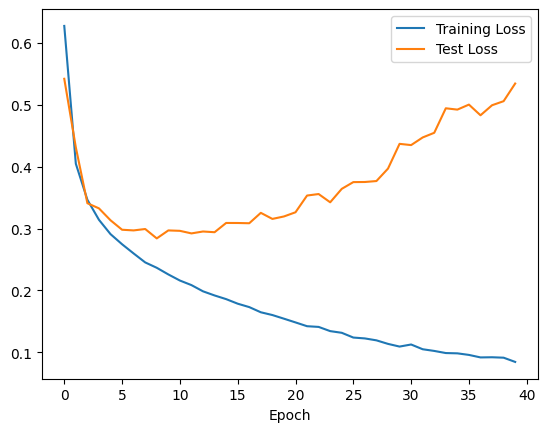

In [18]:
# Plot the training loss and accuracy
plt.plot(tr_loss, label="Training Loss")
plt.plot(te_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

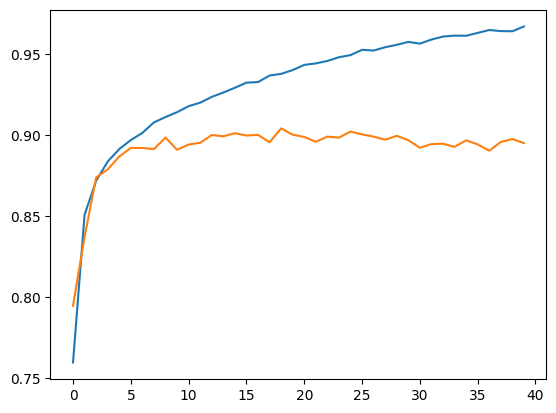

In [19]:
plt.plot(tr_acc, label="Training Accuracy")
plt.plot(te_acc, label="Test Accuracy")